In [ ]:
import data_manager, model_manager, model_inspector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch
from tqdm import tqdm
import os
plt.style.use('ggplot')

In [2]:
mm = model_manager.get_model_list(model_families=['gemma-2', 'llama-3.2', 'llama-3', 'gpt2', 'qwen2.5', 'pythia', 'qwen3'], max_size=27, update=True)
dm = data_manager.DatasetManager()
mm

,model,name.huggingface,n_params.as_str,n_params.as_int,cfg.n_params,cfg.n_layers,cfg.n_heads,cfg.d_model,cfg.d_vocab,cfg.act_fn,cfg.positional_embedding_type,cfg.parallel_attn_mlp,cfg.original_architecture,cfg.normalization_type,tokenizer.name,tokenizer.class,tokenizer.vocab_size,tokenizer.vocab_hash,model_family,model_size
0,gpt2-small,gpt2,85M,84934656,84934656,12,12,768,50257,gelu_new,standard,False,GPT2LMHeadModel,LN,gpt2,GPT2TokenizerFast,50257.0,v8xfIj5kwZX5RwgLU66lZNZUlE4=,gpt2,0.0850
1,gpt2-medium,gpt2-medium,302M,301989888,301989888,24,16,1024,50257,gelu_new,standard,False,GPT2LMHeadModel,LN,gpt2-medium,GPT2TokenizerFast,50257.0,v8xfIj5kwZX5RwgLU66lZNZUlE4=,gpt2,0.3020
2,gpt2-large,gpt2-large,708M,707788800,707788800,36,20,1280,50257,gelu_new,standard,False,GPT2LMHeadModel,LN,gpt2-large,GPT2TokenizerFast,50257.0,v8xfIj5kwZX5RwgLU66lZNZUlE4=,gpt2,0.7080
3,gpt2-xl,gpt2-xl,1.5B,1474560000,1474560000,48,25,1600,50257,gelu_new,standard,False,GPT2LMHeadModel,LN,gpt2-xl,GPT2TokenizerFast,50257.0,v8xfIj5kwZX5RwgLU66lZNZUlE4=,gpt2,1.5000
4,pythia-14m,EleutherAI/pythia-14m,1.2M,1179648,1179648,6,4,128,50304,gelu,rotary,True,GPTNeoXForCausalLM,LN,EleutherAI/pythia-14m,GPTNeoXTokenizerFast,50254.0,96EawM8Lij99W7OBTk0KW2ELUrQ=,pythia,0.0012
5,pythia-31m,EleutherAI/pythia-31m,4.7M,4718592,4718592,6,8,256,50304,gelu,rotary,True,GPTNeoXForCausalLM,LN,EleutherAI/pythia-31m,GPTNeoXTokenizerFast,50254.0,96EawM8Lij99W7OBTk0KW2ELUrQ=,pythia,0.0047
6,pythia-70m,EleutherAI/pythia-70m,19M,18874368,18874368,6,8,512,50304,gelu,rotary,True,GPTNeoXForCausalLM,LN,EleutherAI/pythia-70m,GPTNeoXTokenizerFast,50254.0,96EawM8Lij99W7OBTk0KW2ELUrQ=,pythia,0.0190
7,pythia-160m,EleutherAI/pythia-160m,85M,84934656,84934656,12,12,768,50304,gelu,rotary,True,GPTNeoXForCausalLM,LN,EleutherAI/pythia-160m,GPTNeoXTokenizerFast,50254.0,96EawM8Lij99W7OBTk0KW2ELUrQ=,pythia,0.0850
8,pythia-410m,EleutherAI/pythia-410m,302M,301989888,301989888,24,16,1024,50304,gelu,rotary,True,GPTNeoXForCausalLM,LN,EleutherAI/pythia-410m,GPTNeoXTokenizerFast,50254.0,96EawM8Lij99W7OBTk0KW2ELUrQ=,pythia,0.3020
9,pythia-1b,EleutherAI/pythia-1b,805M,805306368,805306368,16,8,2048,50304,gelu,rotary,True,GPTNeoXForCausalLM,LN,EleutherAI/pythia-1b,GPTNeoXTokenizerFast,50254.0,96EawM8Lij99W7OBTk0KW2ELUrQ=,pythia,0.8050


In [3]:
model_to_test = {
                'gpt-2': ['gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'],
                'llama-3': ['meta-llama/Llama-3.2-1B-Instruct', 'meta-llama/Llama-3.2-3B-Instruct', 'meta-llama/Meta-Llama-3-8B-Instruct'],
                'gemma-2': ['gemma-2-2b-it', 'gemma-2-9b-it'],
                'qwen-3': ['qwen3-1.7b', 'qwen3-4b', 'qwen3-8b'],
                # 'qwen-2.5': ['qwen2.5-0.5b-instruct', 'qwen2.5-1.5b-instruct', 'qwen2.5-3b-instruct', 'qwen2.5-7b-instruct'],
                # 'pythia': ['pythia-1b', 'pythia-2.8b', 'pythia-6.9b']
                }

In [1]:
PROMPT = lambda model: model.tokenizer.bos_token
MAX_TOKENS = 32
NUM_SAMPLES = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
UPDATE = False

NameError: name 'torch' is not defined

In [ ]:
if UPDATE:
    # to_update = ['pythia', 'qwen-2.5', 'qwen-3']
    # to_update = ['qwen-3']
    for model_family, models in model_to_test.items():
        # if model_family not in to_update:
        #     continue
        all_ents = []
        for model_name in models:
            print(f'Processing {model_family} - {model_name}')
            mi = model_inspector.ModelInspector(model_name, dtype='float16', device=DEVICE)
            for i in tqdm(range(NUM_SAMPLES)):

                txt, all_act = mi.generate_with_activations(PROMPT(mi.model), max_len=MAX_TOKENS, sample=True, verbose=False, temperature=0.7)
                ent = mi.calculate_entropy(all_act, num_windows=1)
                ents = [ent.numpy()[0].tolist()]
            
                # save the results
                df = pd.DataFrame([ents], columns=['entropy'])
                df['model_family'] = model_family
                df['model_name'] = model_name
                df['sample'] = i
                all_ents.append(df)
            
            # destroy the model inspector to free up memory
            del mi
            torch.cuda.empty_cache()

        all_ents = pd.concat(all_ents, ignore_index=True)
        
        if not os.path.exists('entropy_families_results'):
            os.makedirs('entropy_families_results')
        all_ents.to_csv(f'entropy_families_results/{model_family}_entropy.csv', index=False)

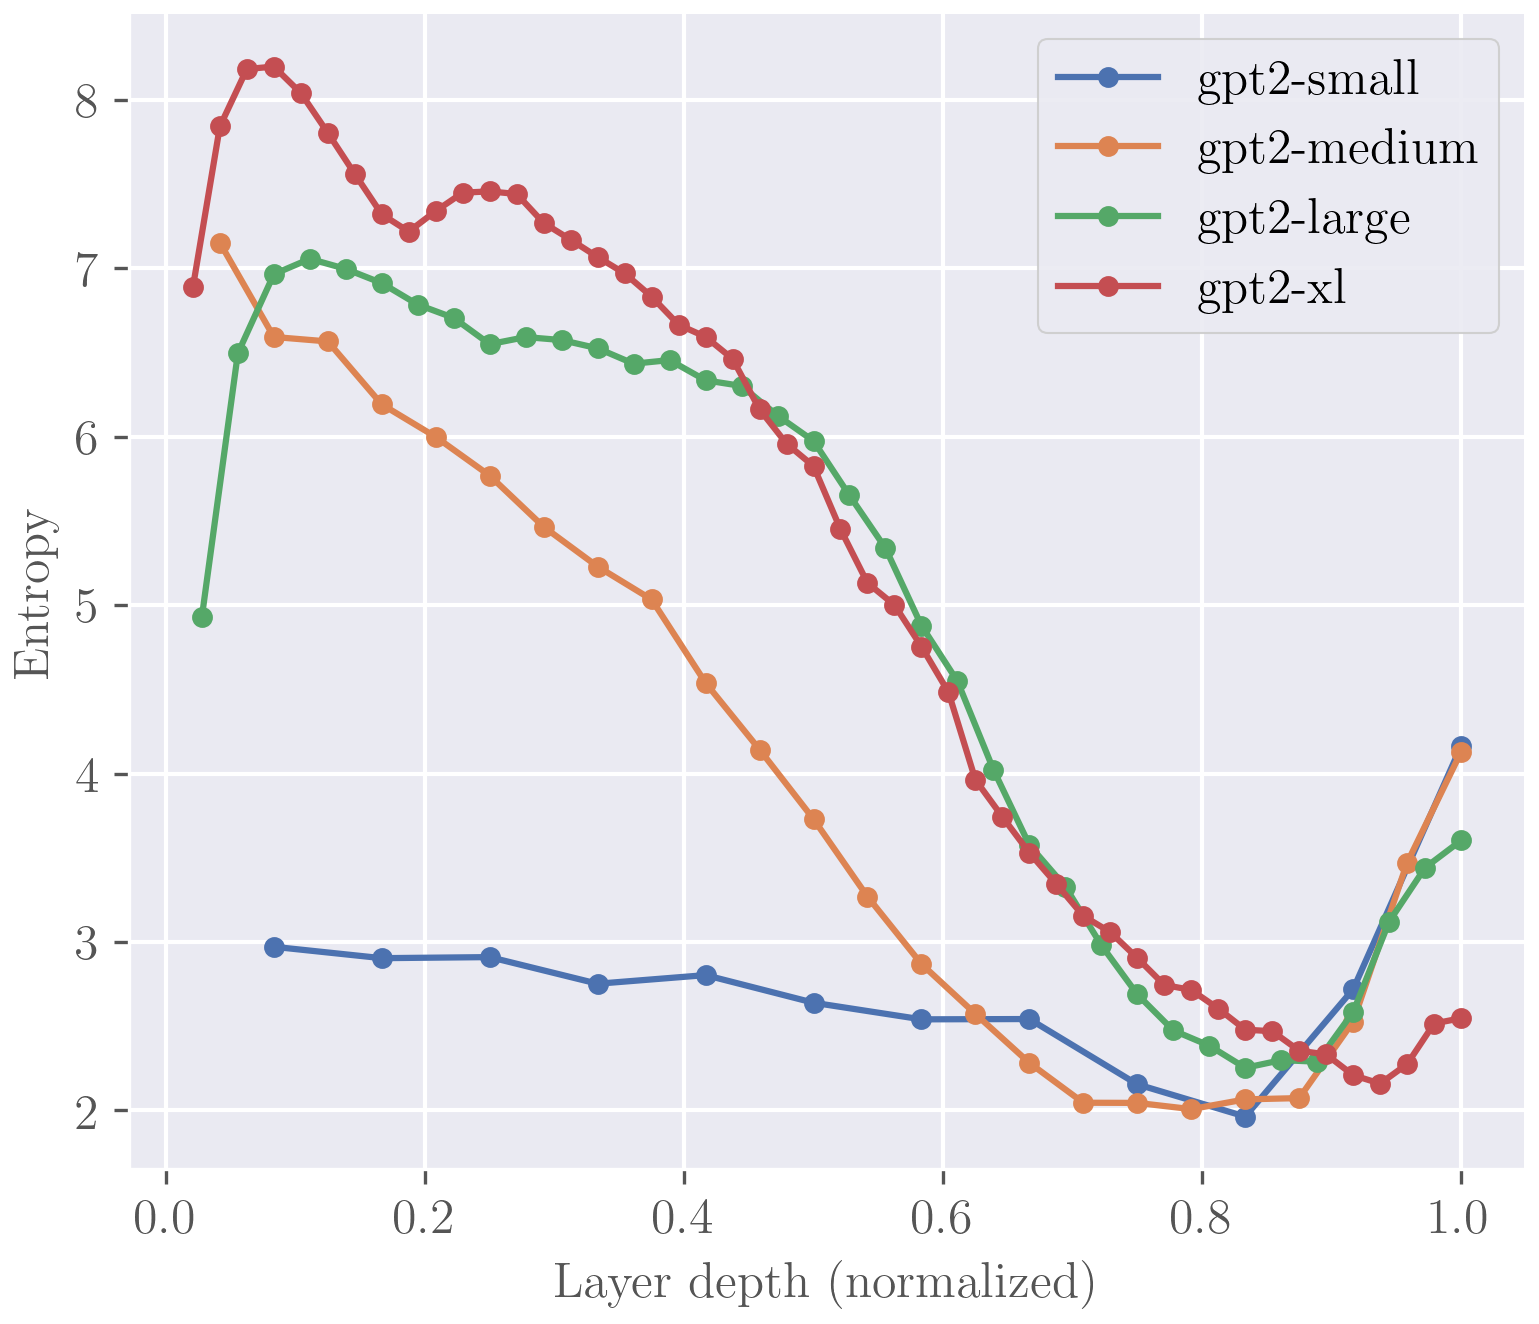

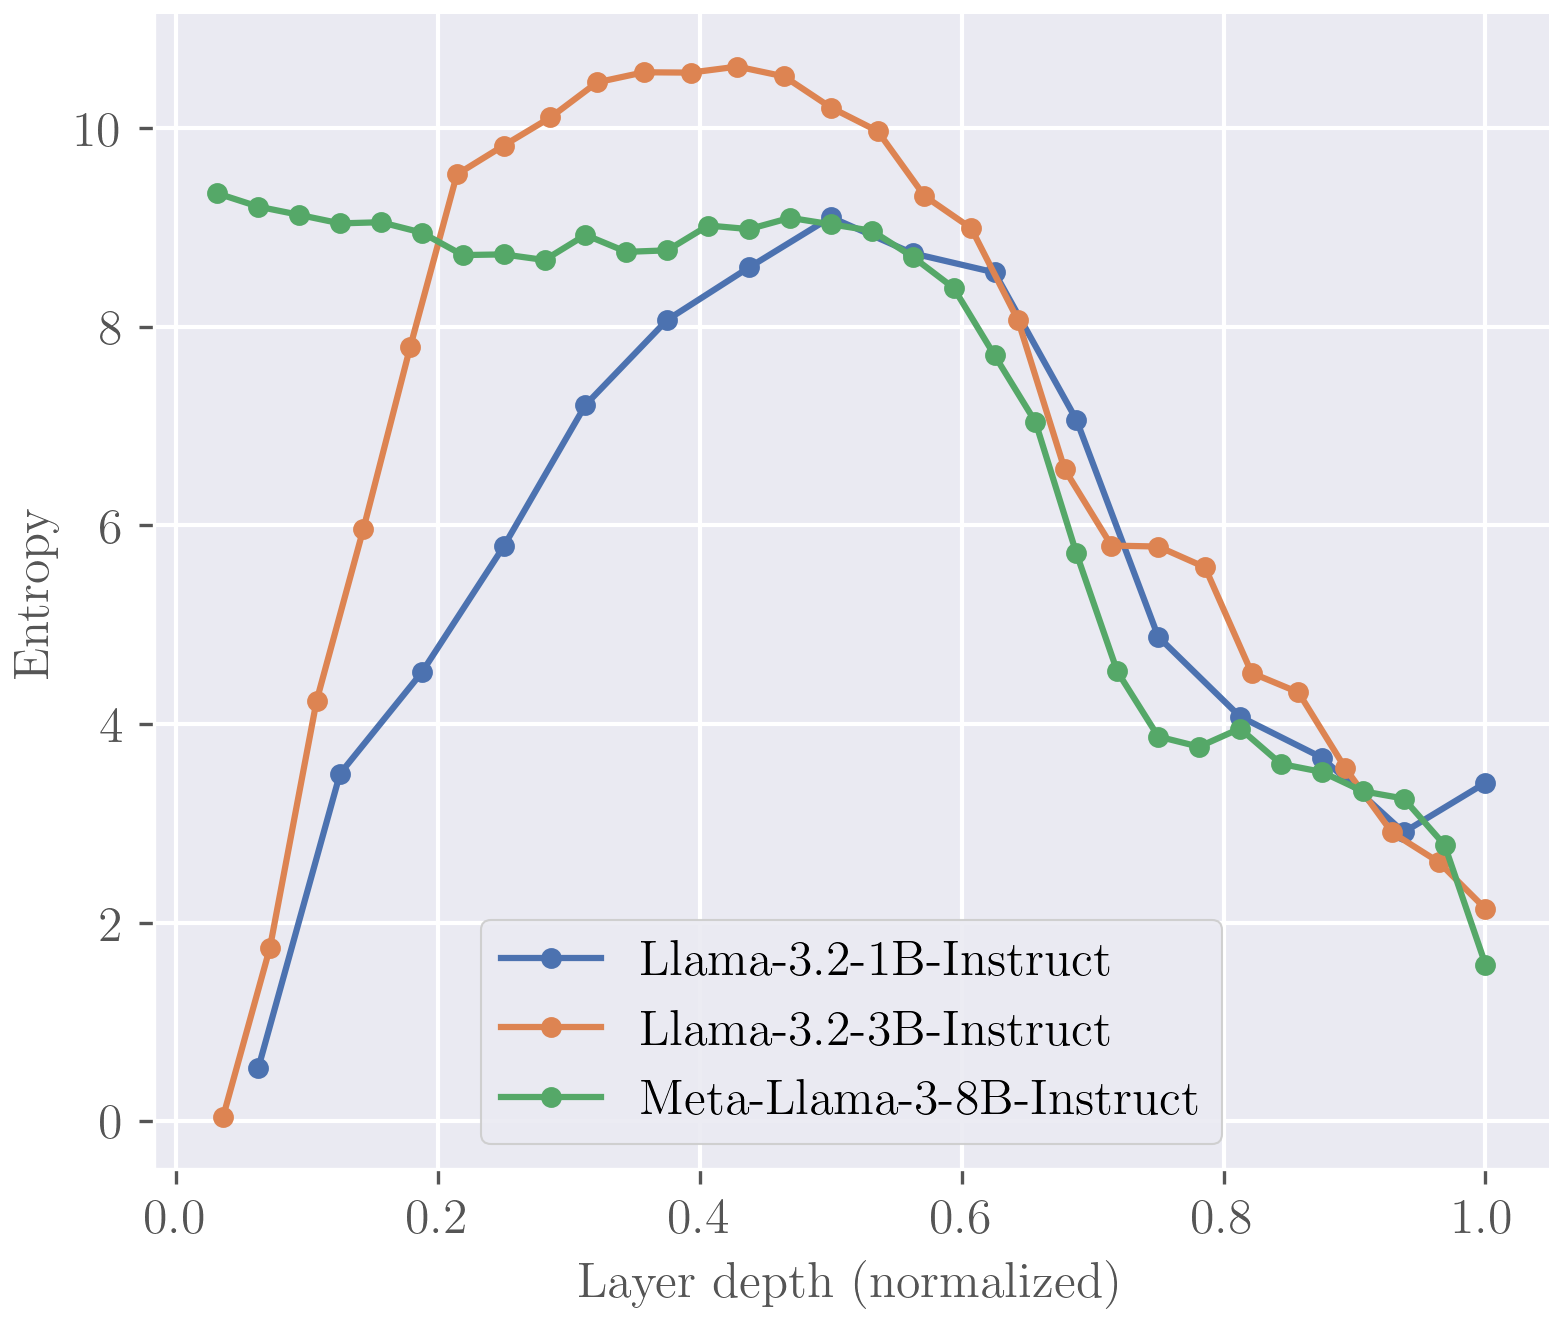

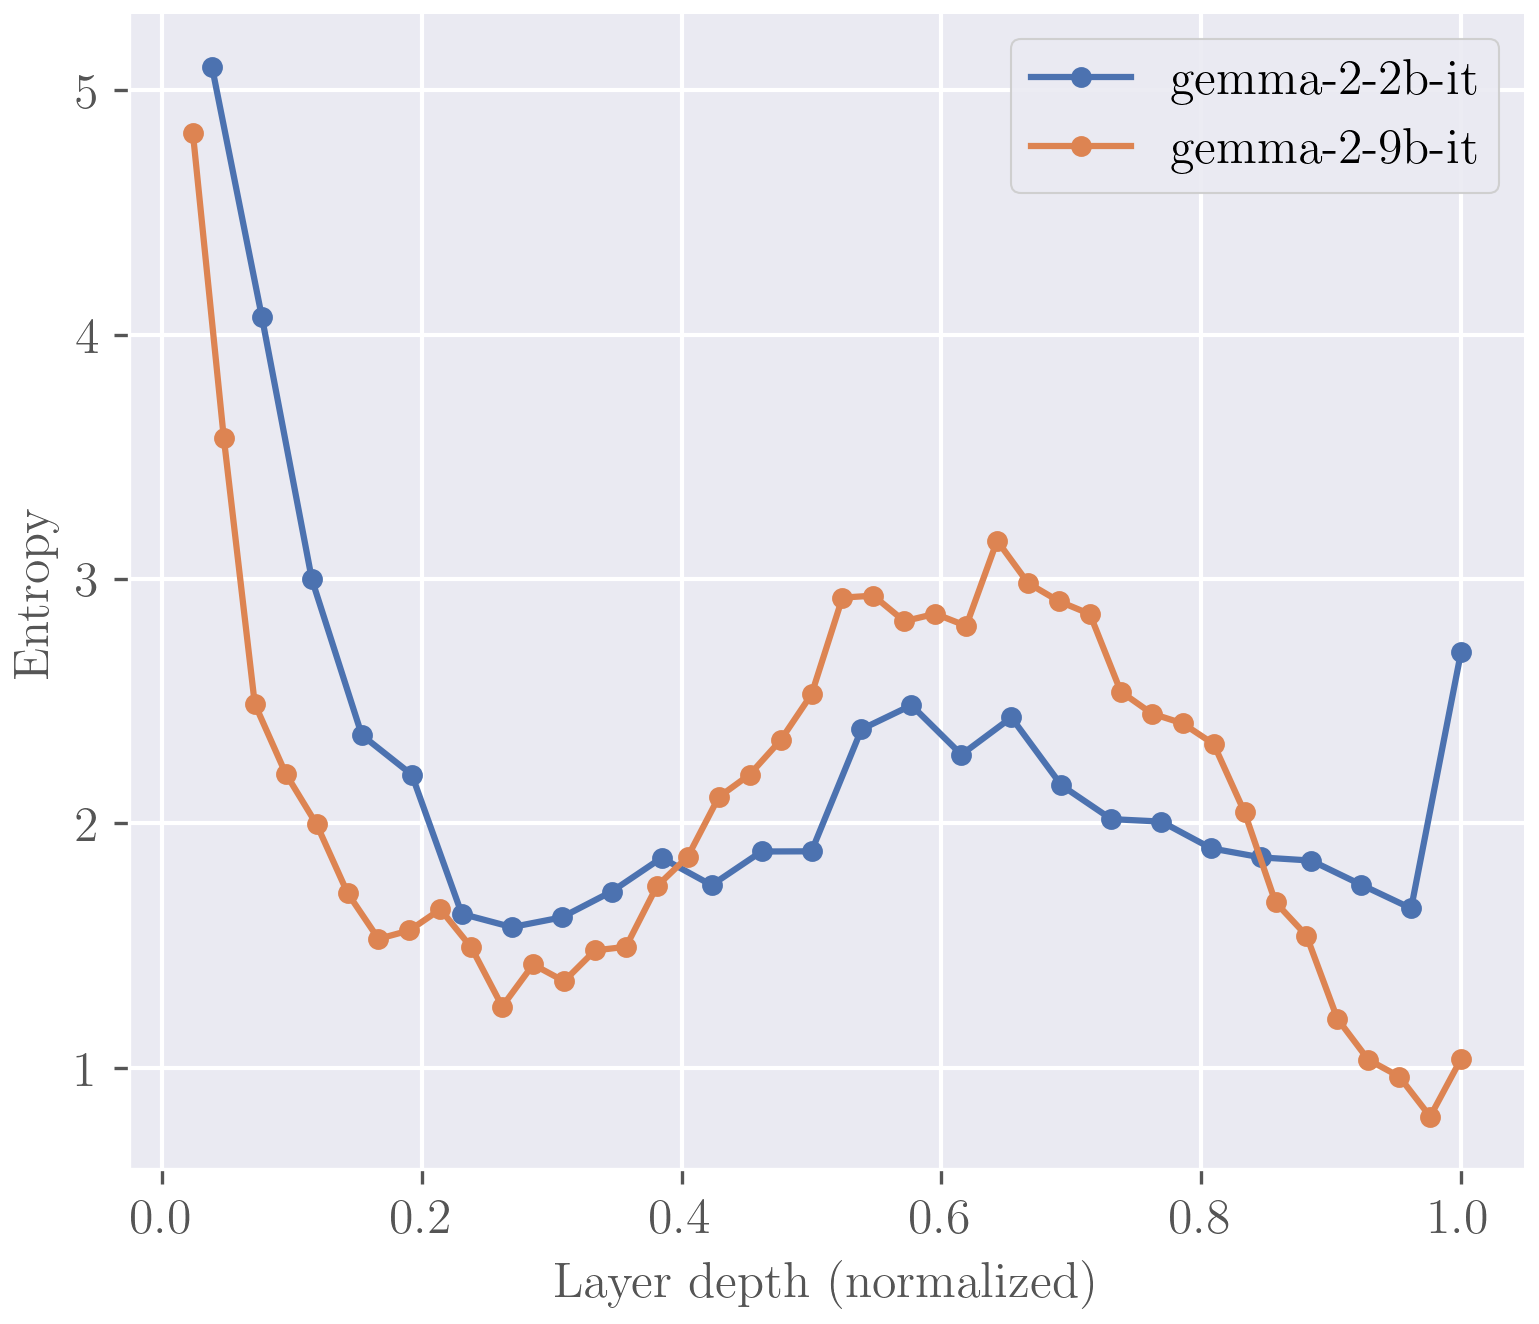

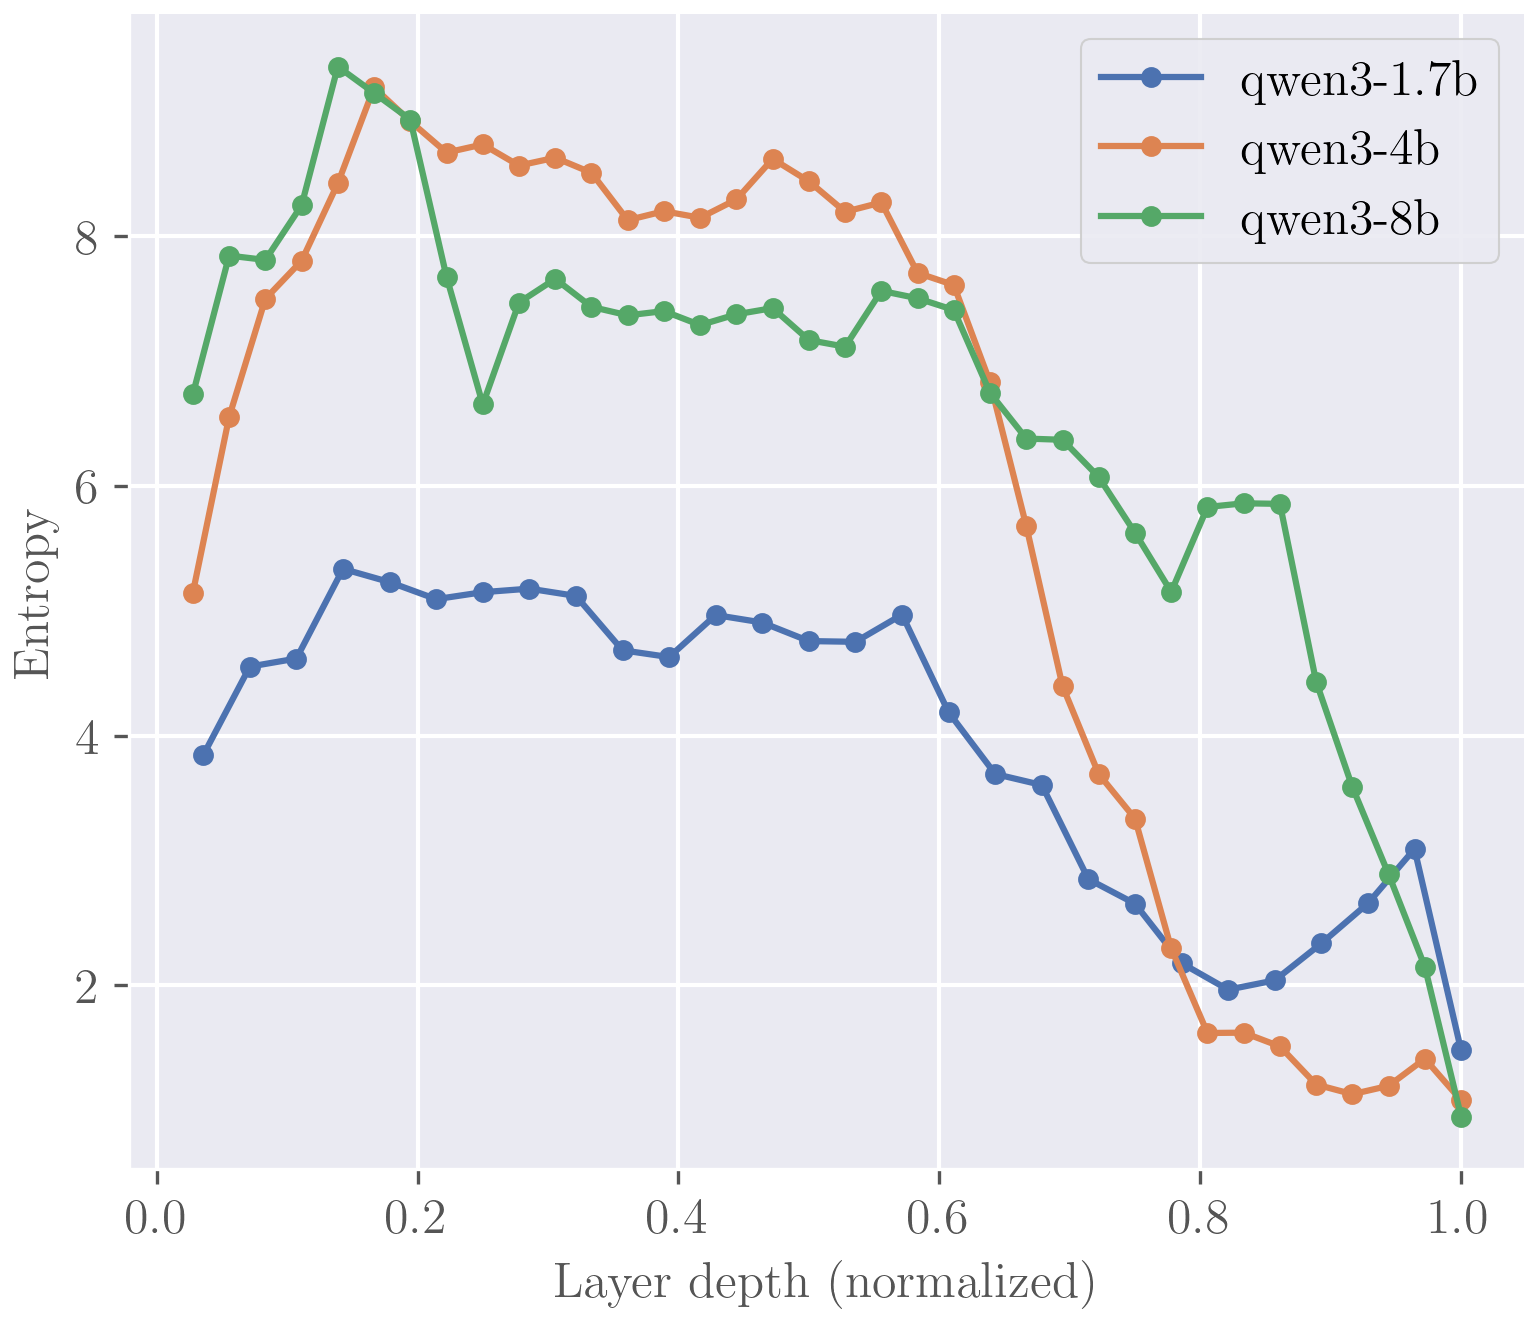

In [ ]:
for model_family, models in model_to_test.items():
    df = pd.read_csv(f'entropy_families_results/{model_family}_entropy.csv')

    # for i,row in df.iterrows():
    plt.figure(figsize=(6, 5))
    for model_name in df.model_name.unique():
        # ent = eval(row.entropy)
        
        ent = eval(df[df.model_name == model_name].entropy.iloc[0])
        n_layers = np.arange(1, len(ent)+1)
        n_layers = n_layers / n_layers[-1] 

        # ax[j].plot(ent, marker='o', label=row.model)
        
        plt.plot(n_layers, ent, marker='o', label=model_name.split('/')[-1])
    plt.xlabel('Layer depth (normalized)')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()

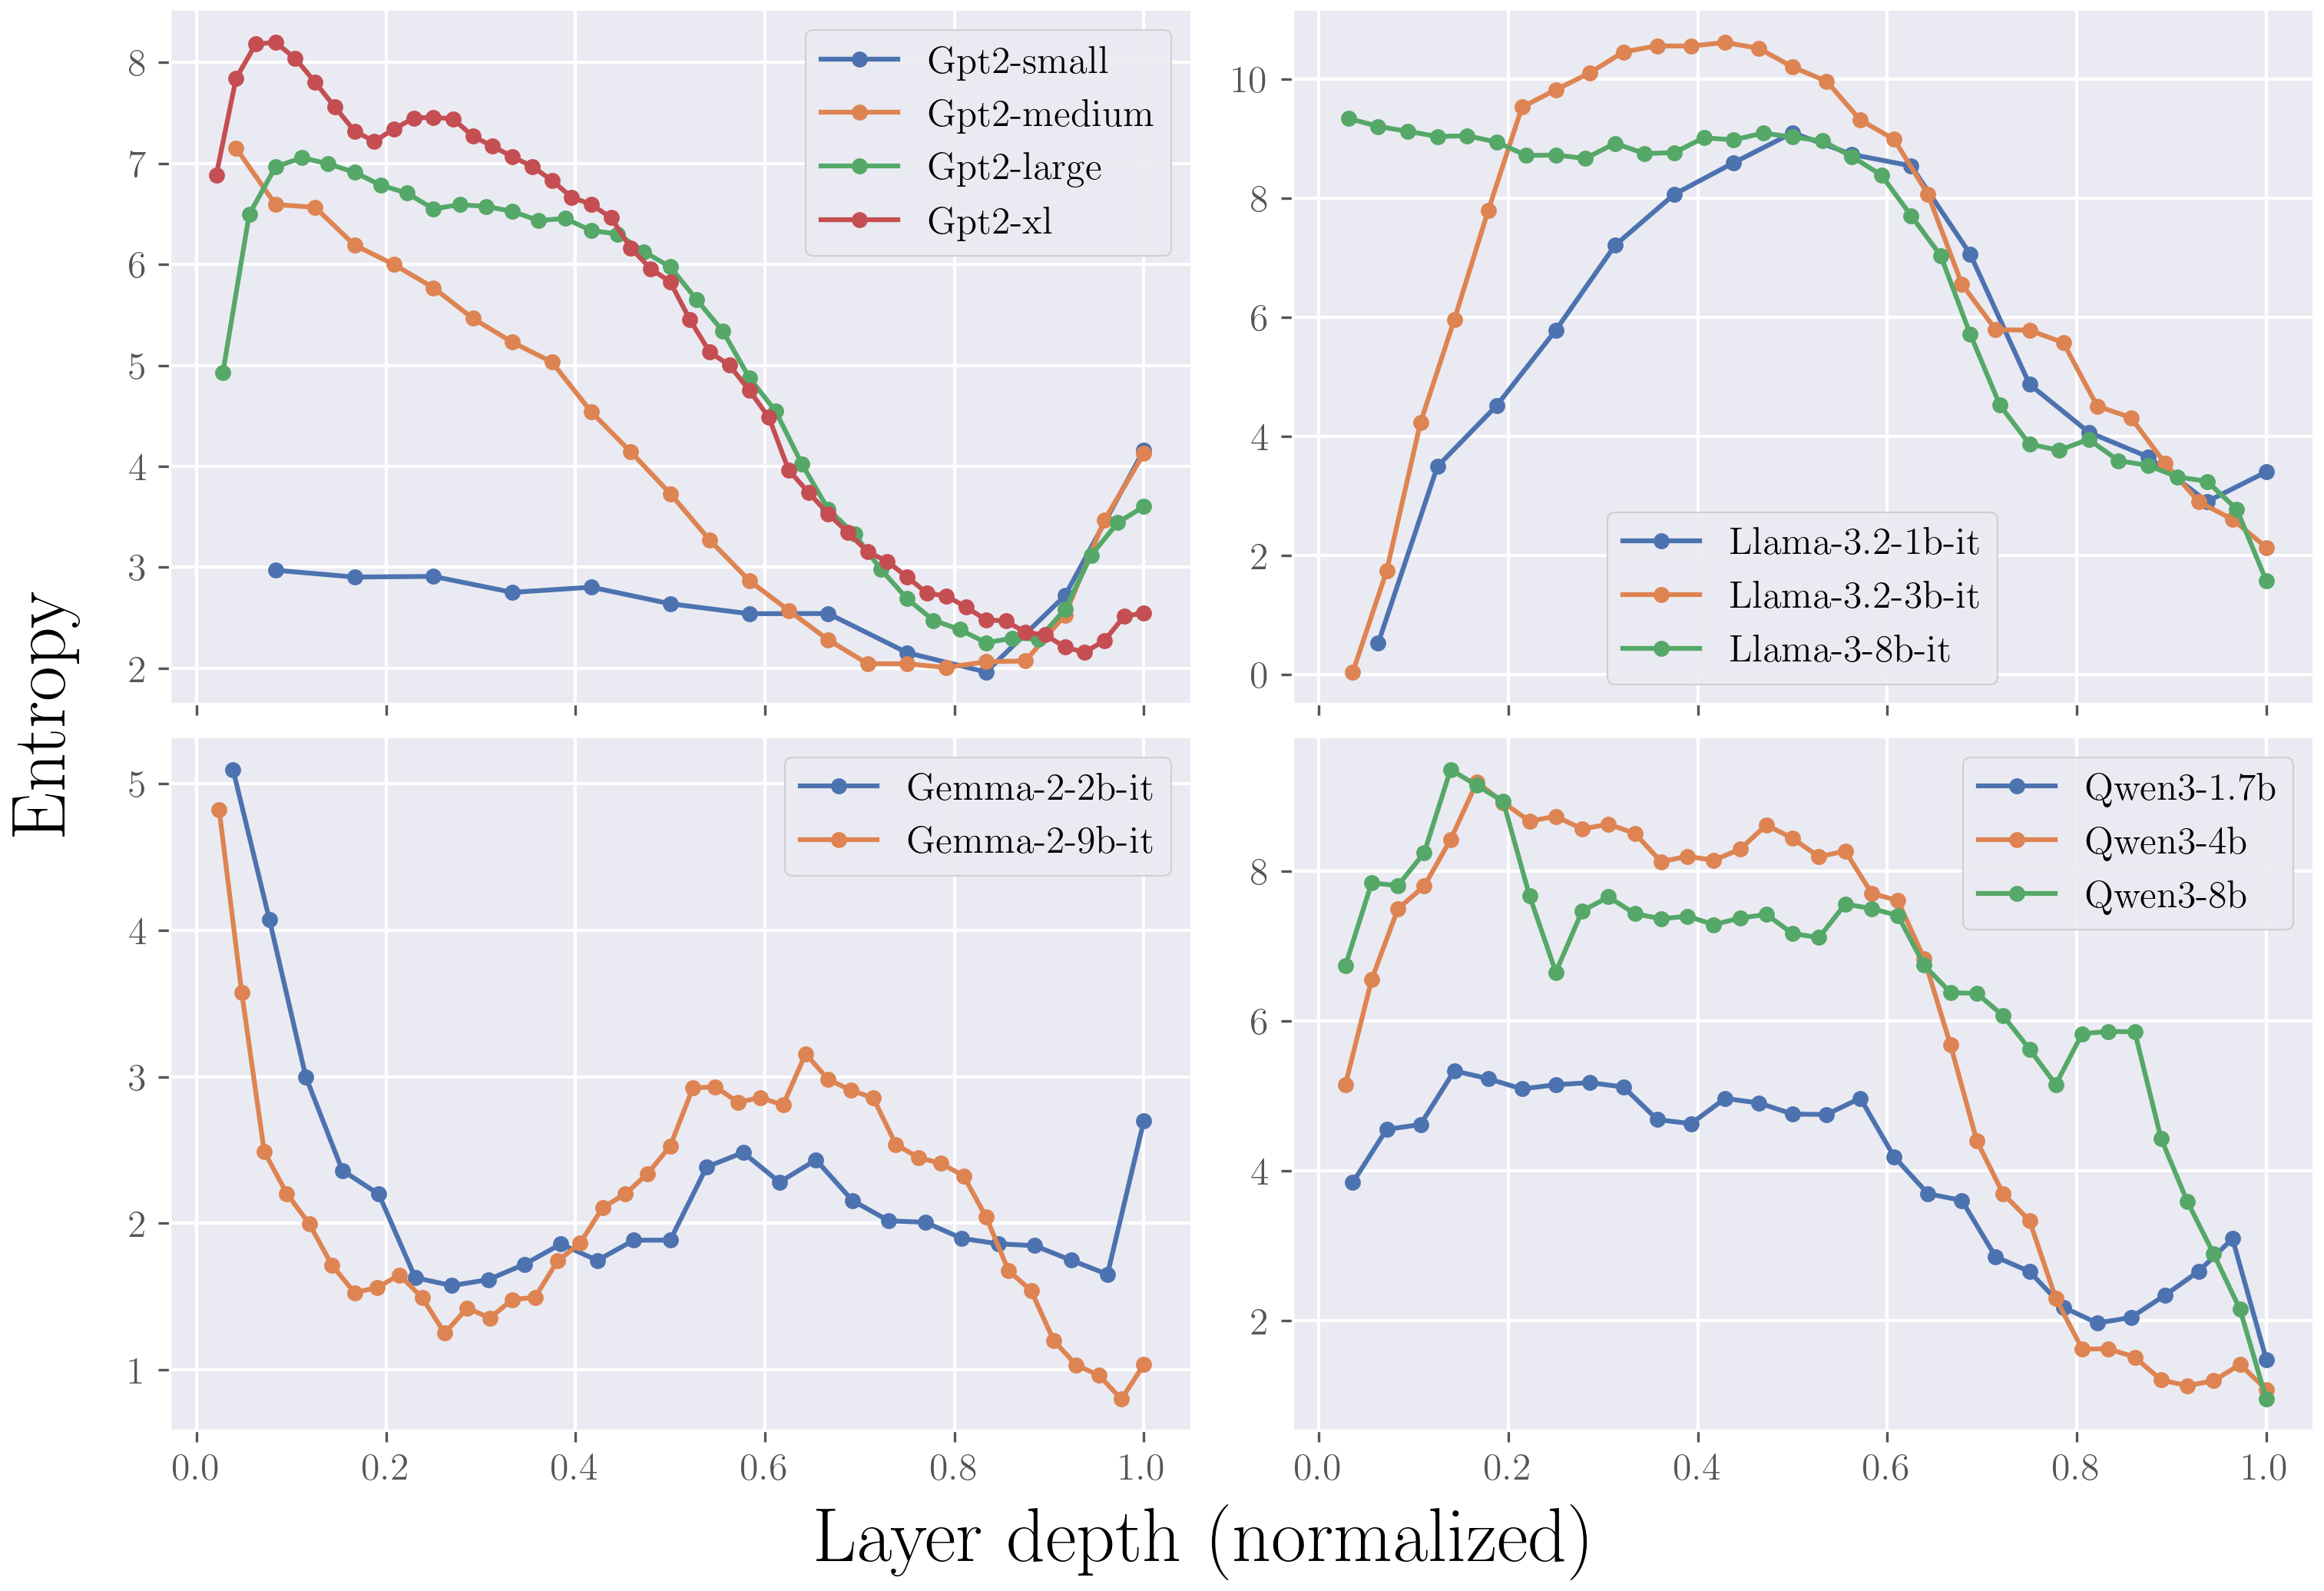

In [ ]:
# plot in a mosaic layout 3x2
fig = plt.figure(figsize=(12, 8), constrained_layout=False)
ax = fig.subplot_mosaic('''AB
                           CD''', sharex=True, sharey=False)

fig.subplots_adjust(hspace=0.05, wspace=0.1)

for i, (model_family, models) in enumerate(model_to_test.items()):
    df = pd.read_csv(f'entropy_families_results/{model_family}_entropy.csv')

    for j, model_name in enumerate(df.model_name.unique()):
        # ent = eval(df[df.model_name == model_name].entropy.iloc[0])
        ent = eval(df[df.model_name == model_name].entropy.iloc[0])
        n_layers = np.arange(1, len(ent)+1)
        n_layers = n_layers / n_layers[-1]

        ax[chr(65+i)].plot(n_layers, ent, marker='o', label=model_name.split('/')[-1].replace('Instruct', 'it').replace('Meta-', '').capitalize())
        # ax[chr(65+i)].set_title(model_name.split('/')[-1])
        # ax[chr(65+i)].set_xlabel('Layer depth (normalized)')
        # ax[chr(65+i)].set_ylabel('Entropy')
        ax[chr(65+i)].legend(fontsize=12, loc='upper right')

ax['B'].legend(loc='lower center')

# ax['A'].set_ylabel('Entropy', fontsize=24)
# ax['C'].set_ylabel('Entropy', fontsize=24)

# ax['C'].set_xlabel('Layer depth (normalized)', fontsize=24)
# ax['D'].set_xlabel('Layer depth (normalized)', fontsize=24)

fig.text(0.5, 0.05, 'Layer depth (normalized)', ha='center', va='center', fontsize=24)
fig.text(0.08, 0.5, 'Entropy', ha='center', va='center', rotation='vertical', fontsize=24)

fig.savefig('plots/entropy_families.pdf', bbox_inches='tight', dpi=300)

In [8]:
X, y, size, family = [], [], [], []

for model_family, models in model_to_test.items():
    df = pd.read_csv(f'entropy_families_results/{model_family}_entropy.csv')
    X.append(df.entropy.apply(eval).tolist())
    y.append(df.model_name.tolist())
    family.append([model_family] * len(df))
    # size.append(mm[mm.model_name == models[0]].size.values[0])  # Assuming all models in the family have the same size
    curr_sizes = []
    for model_name in df.model_name.tolist():
        curr_sizes.append(mm[mm.model == model_name]['n_params.as_int'].values[0])
        # size.append(mm[mm.model == model_name]['n_params.as_int'].values[0])
    #normalize the size between 0 and 1
    curr_sizes = curr_sizes / np.max(curr_sizes)
    size.append(curr_sizes)

# squeeze the lists
X = [item for sublist in X for item in sublist]
y = [item for sublist in y for item in sublist]
size = [item for sublist in size for item in sublist]
family = [item for sublist in family for item in sublist]

# pad the sequences
max_len = max(len(x) for x in X)
X_padded = np.array([np.pad(x, (0, max_len - len(x)), 'constant', constant_values=0) for x in X])
# 
# pad the sequence to the same lenght by interpolating
# max_len = max(len(x) for x in X)
# X_padded = np.array([np.interp(np.linspace(0, len(x)-1, max_len), np.arange(len(x)), x) for x in X])

X_padded.shape

(768, 48)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# normalize the data
# X_padded = F.normalize(torch.tensor(X_padded), dim=1).numpy()

pca = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=20, verbose=1, init='pca')
X_pca = pca.fit_transform(X_padded)

/home/christopher.irwin/Antani-Lens/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 768 samples in 0.000s...
[t-SNE] Computed neighbors for 768 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 768 / 768
[t-SNE] Mean sigma: 1.128371
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.025452
[t-SNE] KL divergence after 300 iterations: 0.635758


gpt2-small
gpt2-medium
gpt2-large
gpt2-xl
gemma-2-2b-it
gemma-2-9b-it
meta-llama/Llama-3.2-1B-Instruct
meta-llama/Llama-3.2-3B-Instruct
meta-llama/Meta-Llama-3-8B-Instruct
qwen3-1.7b
qwen3-4b
qwen3-8b


/tmp/ipykernel_1817931/1376713275.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


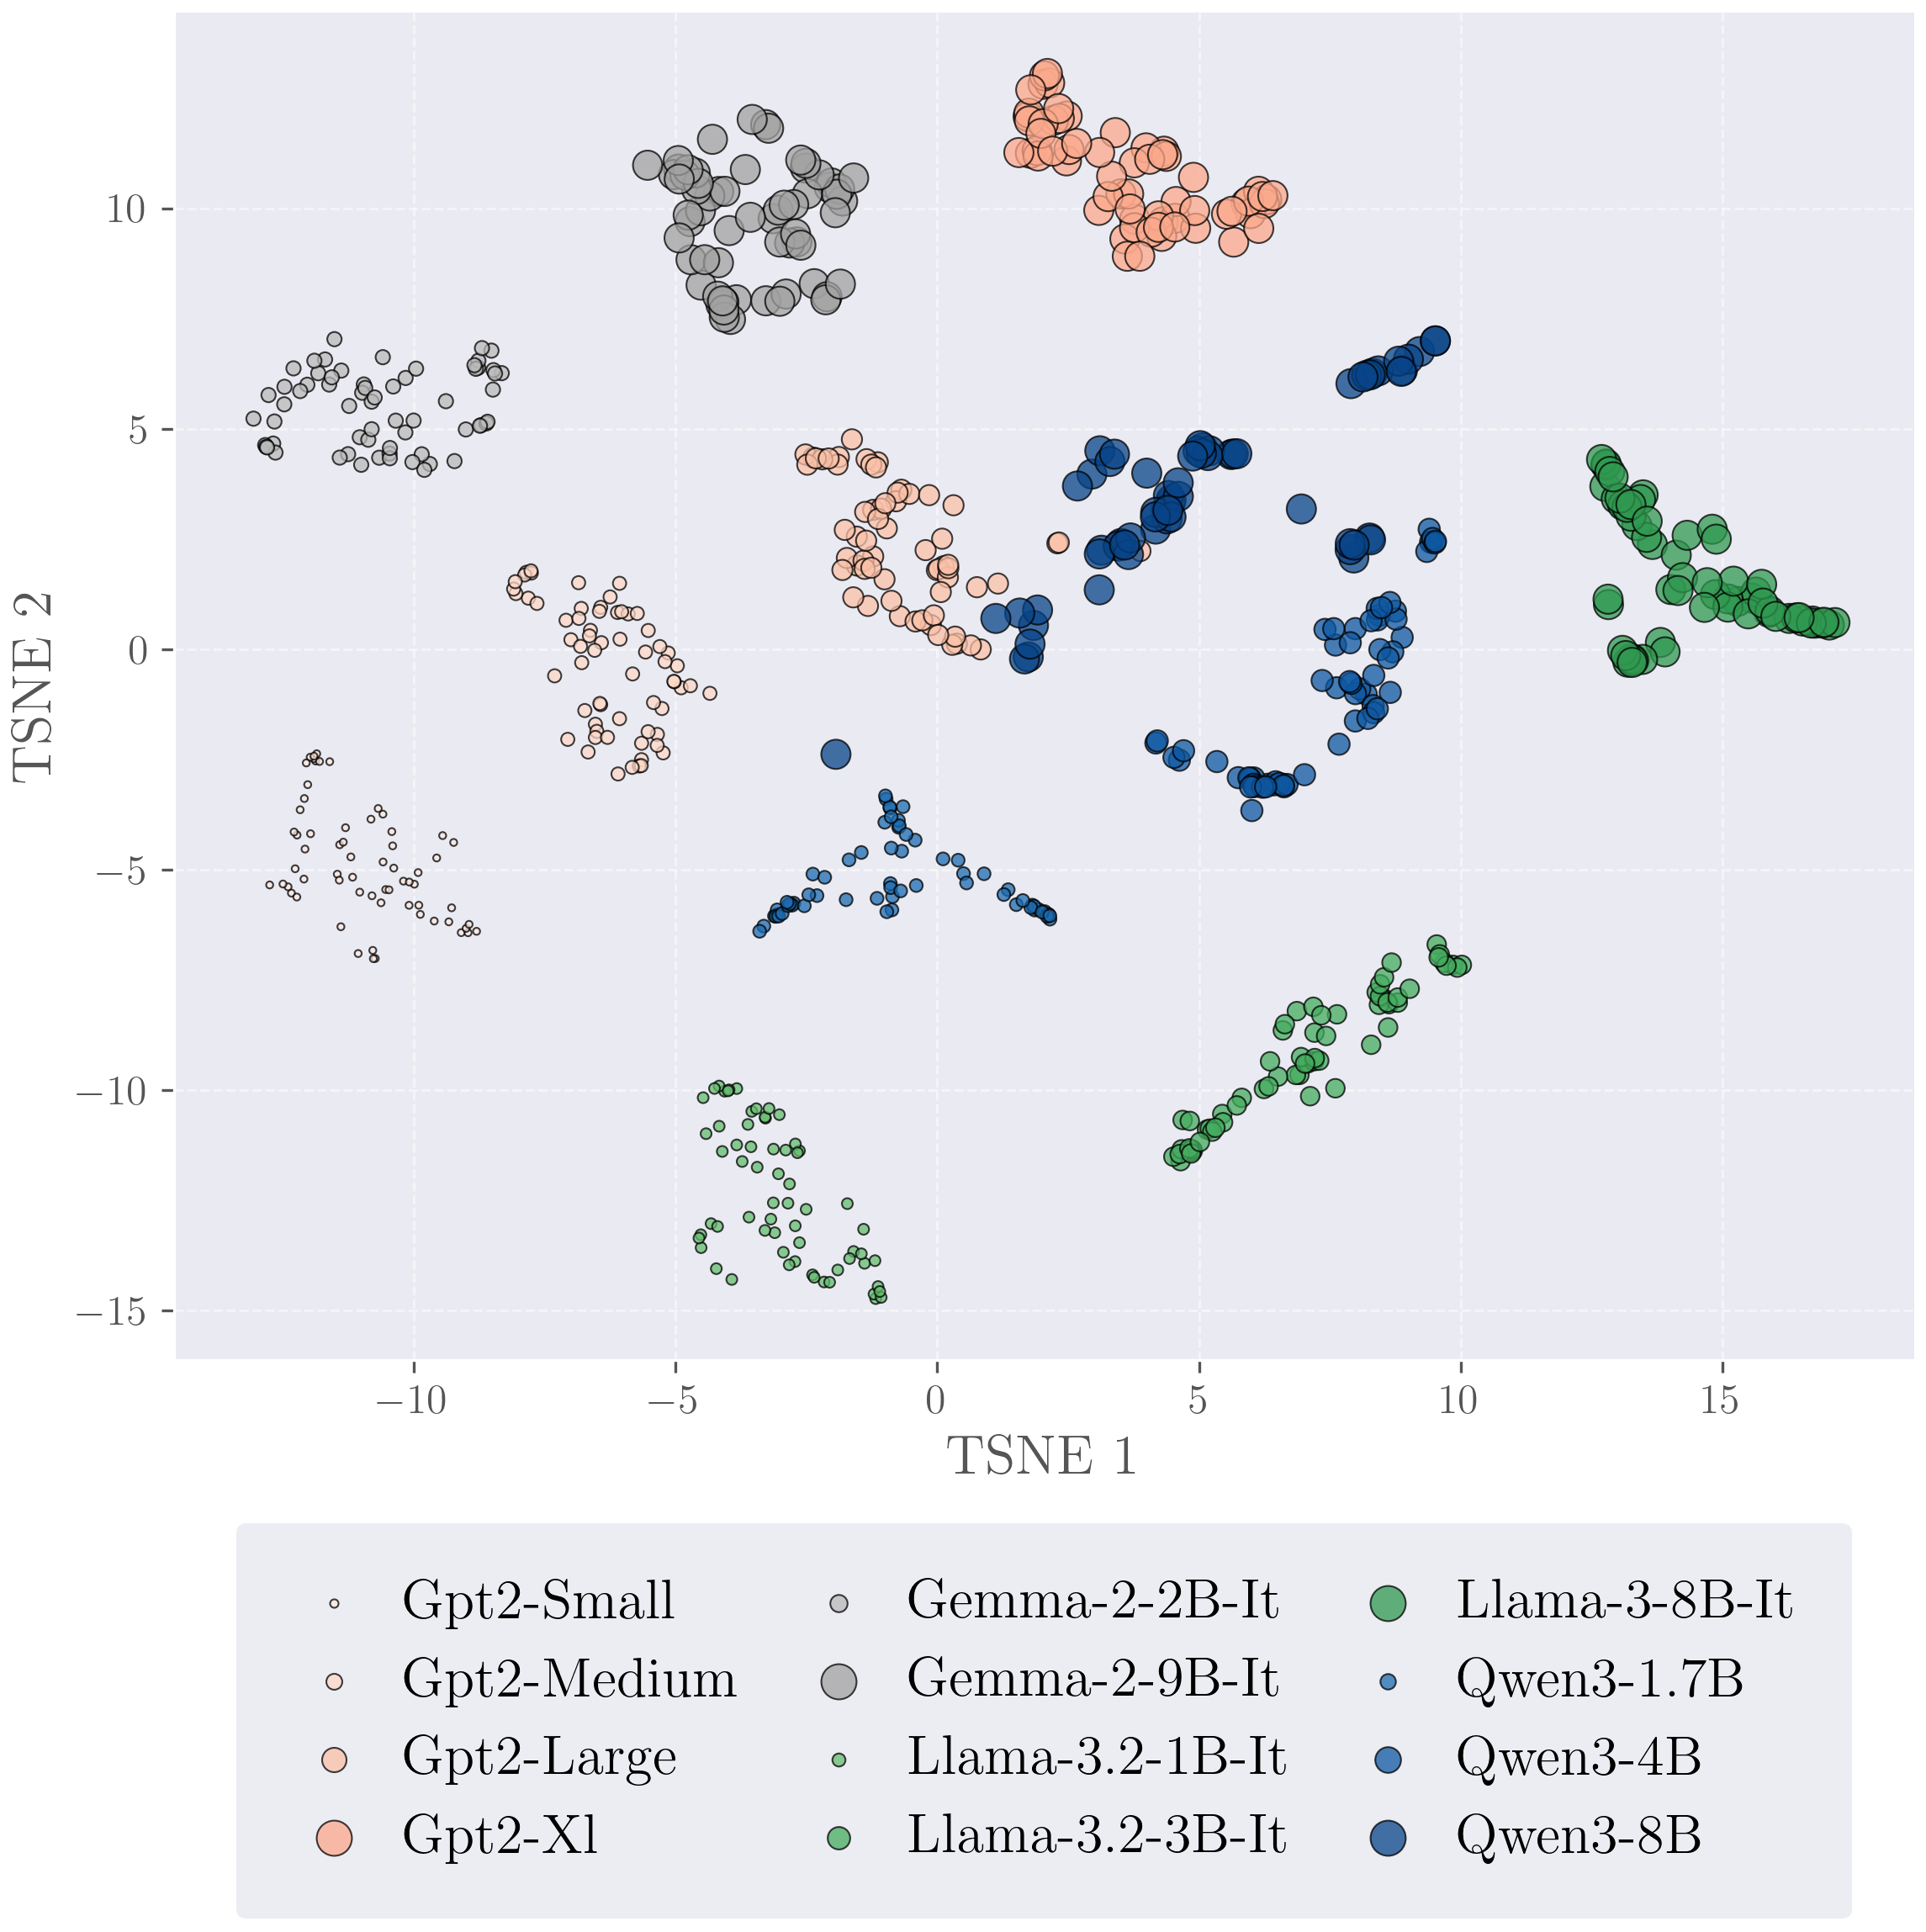

In [ ]:
import matplotlib as mpl

# # Set up high-quality figure parameters
# mpl.rcParams.update({
#     "font.size": 18,
#     "axes.labelsize": 20,
#     "axes.titlesize": 22,
#     "legend.fontsize": 12,
#     "xtick.labelsize": 16,
#     "ytick.labelsize": 16,
#     "figure.dpi": 200,
#     "axes.linewidth": 1.5,
#     "lines.linewidth": 2,
#     "legend.frameon": True,
#     "legend.framealpha": 0.95,
#     "legend.fancybox": True,
#     "legend.edgecolor": "black",
#     "savefig.bbox": "tight"
# })


fig, ax = plt.subplots(figsize=(8, 8))

# unique_families = sorted(set(y))
# gemma-2-2b-it
# gemma-2-9b-it
# gpt2-large
# gpt2-medium
# gpt2-small
# gpt2-xl
# meta-llama/Llama-3.2-1B-Instruct
# meta-llama/Llama-3.2-3B-Instruct
# meta-llama/Meta-Llama-3-8B-Instruct
# qwen3-1.7b
# qwen3-4b
# qwen3-8b

unique_models = ['gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'gemma-2-2b-it', 'gemma-2-9b-it',
                   'meta-llama/Llama-3.2-1B-Instruct', 'meta-llama/Llama-3.2-3B-Instruct', 'meta-llama/Meta-Llama-3-8B-Instruct',
                   'qwen3-1.7b', 'qwen3-4b', 'qwen3-8b']

# palette = sns.color_palette("tab20", len(unique_models))
palettes = {'qwen3': sns.color_palette("Blues", len(unique_models)),
            'llama-3': sns.color_palette("Greens", len(unique_models)),
            'gpt2': sns.color_palette("Reds", len(unique_models)),
            'gemma-2': sns.color_palette("Greys", len(unique_models))}

# make a palette with the same color for model families but different shades for each model
# palette = sns.color_palette("viridis", len(unique_models))
fams = ['qwen3', 'llama-3', 'gpt2', 'gemma-2']


for i, model_name in enumerate(unique_models):
    print(model_name)
    p = [l.lower() in model_name.lower() for l in fams].index(True)
    indices = [j for j, fam in enumerate(y) if fam == model_name]
    
    f = family[indices[0]]  # Get the family for the first model in the indices
    ax.scatter(
        X_pca[indices, 0], X_pca[indices, 1],
        label=model_name.replace('meta-llama/', '').replace('Meta-', '').replace('Instruct', 'it').title(),
        # c=[palette[i]], s=20, alpha=0.75, edgecolor='black', linewidth=0.5
        c=palettes[fams[p]][i], s=np.array(size)[indices]*70, alpha=0.75, edgecolor='black', linewidth=0.5
    )

ax.set_xlabel('TSNE 1', fontsize=16)
ax.set_ylabel('TSNE 2', fontsize=16)
# ax.set_title('PCA Clustering of Model Entropy', pad=20)
# ax.legend(title="Model Family", loc='best', markerscale=1.2, borderpad=1)
# put legend outside the plot
# ax.legend(title="Model Name", loc='upper right', bbox_to_anchor=(1.3, 1))

# put legend at the bottom of the plot in horizontal layout
ax.legend(title="", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=16, markerscale=1.2, borderpad=1, frameon=True, fancybox=True, edgecolor='white',
          title_fontsize='13', labelspacing=0.5, handletextpad=0.5, handlelength=1.5, columnspacing=1.0)

# ax.legend(title
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)
plt.tight_layout()
plt.savefig('plots/entropy_family_tsne.pdf', bbox_inches='tight', dpi=300)
plt.show()